# Unsupervised Dimensionality Reduction
## t-Distributed Stochastic Neighbor Embedding (t-SNE)

In this notebook we will explore t-SNE to reduce the dimensionality of some high dimensional data to a lower order representation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.18.0


## t-SNE Code
The code below was taken from [Laurens van der Maaten website](https://lvdmaaten.github.io/tsne/).

In [2]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

import numpy as np
import pylab


def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print(("Computing P-values for point %d of %d..." % (i, n)))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print(("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta))))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, max_iter=1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[list(range(n)), list(range(n))] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            C = np.sum(P * np.log(P / Q))
            print(("Iteration %d: error is %f" % (iter + 1, C)))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


## Example 1: The MNIST Dataset

In this example we will look at a subset of the MNIST dataset

In [3]:
mnist = keras.datasets.mnist   #The original handwritten digit MNIST
#mnist = keras.datasets.fashion_mnist   #A tricky version that uses images of fashion items
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images=train_images/255.0

print(np.shape(train_images))
X=np.reshape(train_images[:2500],(2500,784))
labels=train_labels[:2500]
print(np.shape(X))

(60000, 28, 28)
(2500, 784)


In [4]:
print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
Y=tsne(X,2,50,20.0,max_iter=500)

Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2500...
Computing P-values for point 500 of 2500...
Computing P-values for point 1000 of 2500...
Computing P-values for point 1500 of 2500...
Computing P-values for point 2000 of 2500...
Mean value of sigma: 2.087350
Iteration 10: error is 23.533299
Iteration 20: error is 21.116468
Iteration 30: error is 18.568553
Iteration 40: error is 17.761424
Iteration 50: error is 17.228347
Iteration 60: error is 17.073417
Iteration 70: error is 16.894022
Iteration 80: error is 16.779733
Iteration 90: error is 16.685350
Iteration 100: error is 16.615502
Iteration 110: error is 2.483756
Iteration 120: error is 2.193171
Iteration 130: error is 1.983131
Iteration 140: error is 1.831874
Iteration 150: error is 1.718251
Iteration 160: error is 1.630650
Iteration 170: error is 1.560919
Iteration 180: error is 1.504342
Iteration 

(2500, 2)


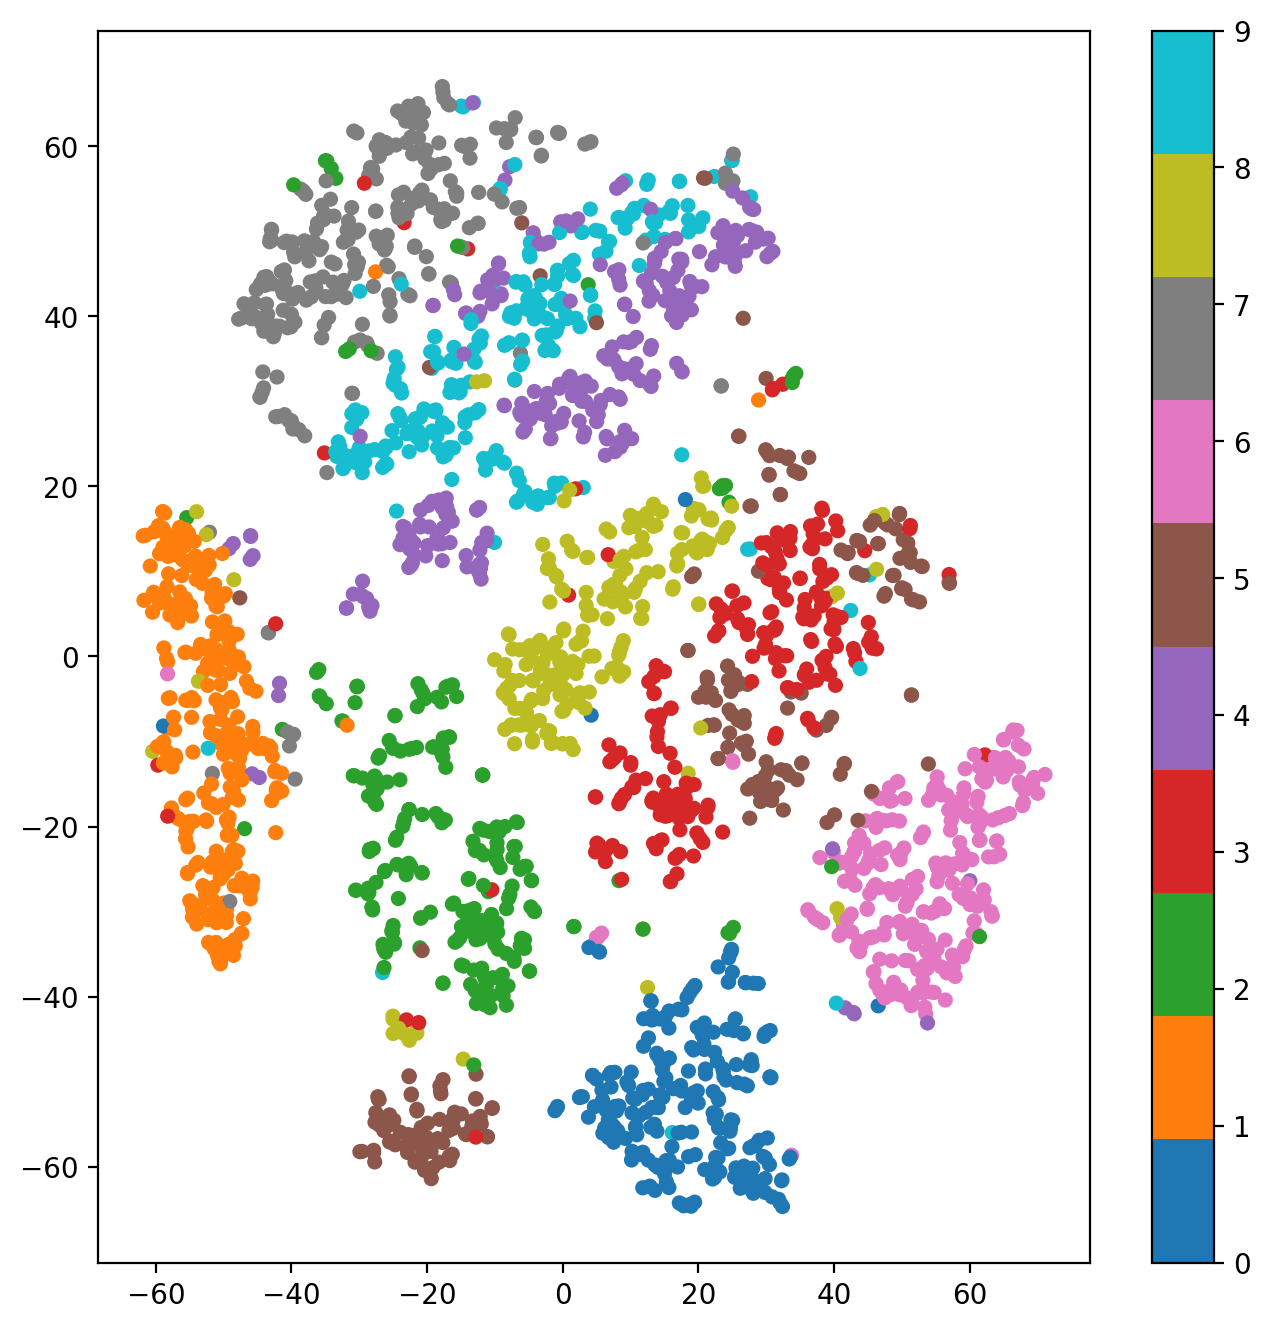

In [5]:
print(np.shape(Y))
fig,ax=plt.subplots(figsize=(8,8))
im=ax.scatter(Y[:,0],Y[:,1],20,labels,cmap="tab10")
cb = fig.colorbar(im) #Get the colorbar for the range of z values

## Example 2: Gaussian clouds
This example was taken from the https://machine-learning-for-physicists.org course. There is lots of excellent background material on that site and like the original notebooks these notebooks are released under the creative commons license.

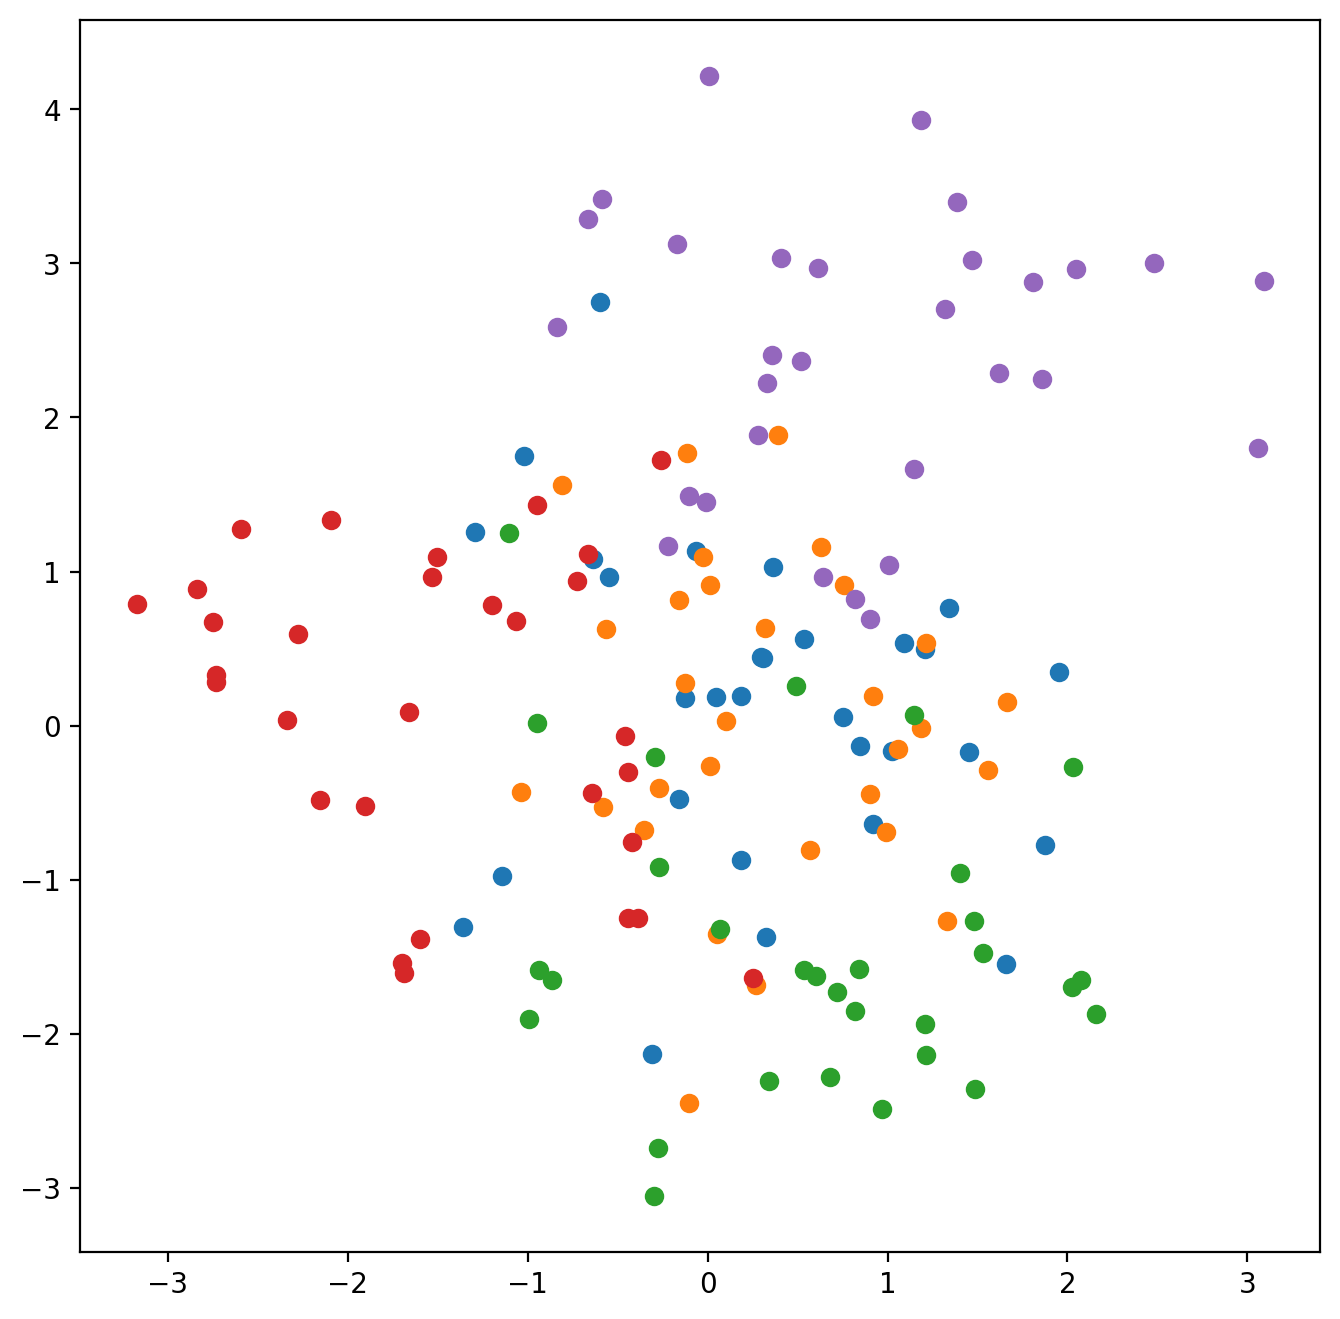

In [6]:
# produce a high-dimensional data set, composed of a few Gaussian point clouds in high-dimensional space

n_dim=100 # a really high-dimensional space

n_clusters=5 # number of clusters, i.e. clouds
N_cluster_points=30 # number of points inside each cluster
N=n_clusters*N_cluster_points # total number of points

Gauss_spread=1.0 # size of each cluster (cloud)

X=np.zeros([N,n_dim])

for j in range(n_clusters):
    Xmean=np.random.randn(n_dim) # the center position of the cluster
    X[j*N_cluster_points:(j+1)*N_cluster_points,:]=Xmean[None,:]+Gauss_spread*np.random.randn(N_cluster_points,n_dim)

# plot these points in a projection into 2D space
# color them according to the cluster they belong to!

fig,ax=plt.subplots(figsize=(8,8))
for j in range(n_clusters):
    X0=X[j*N_cluster_points:(j+1)*N_cluster_points,0]
    X1=X[j*N_cluster_points:(j+1)*N_cluster_points,1]    
    ax.scatter(X0,X1)


Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 150...
Mean value of sigma: 4.963764
Iteration 10: error is 9.948676
Iteration 20: error is 9.618467
Iteration 30: error is 10.705100
Iteration 40: error is 10.368301
Iteration 50: error is 10.404811
Iteration 60: error is 11.016341
Iteration 70: error is 10.797512
Iteration 80: error is 10.659618
Iteration 90: error is 10.473415
Iteration 100: error is 10.794604
Iteration 110: error is 1.324190
Iteration 120: error is 0.846271
Iteration 130: error is 0.405105
Iteration 140: error is 0.301238
Iteration 150: error is 0.265480
Iteration 160: error is 0.254462
Iteration 170: error is 0.251819
Iteration 180: error is 0.251008
Iteration 190: error is 0.250539
Iteration 200: error is 0.250067
Iteration 210: error is 0.249549
Iteration 220: error is 0.249062
Iteration 230: error is 0.248601
Iteration 240: error is 0.248173
Iteration 250: error is 0.247787
Iteration 260: error is 0.247448
Iter

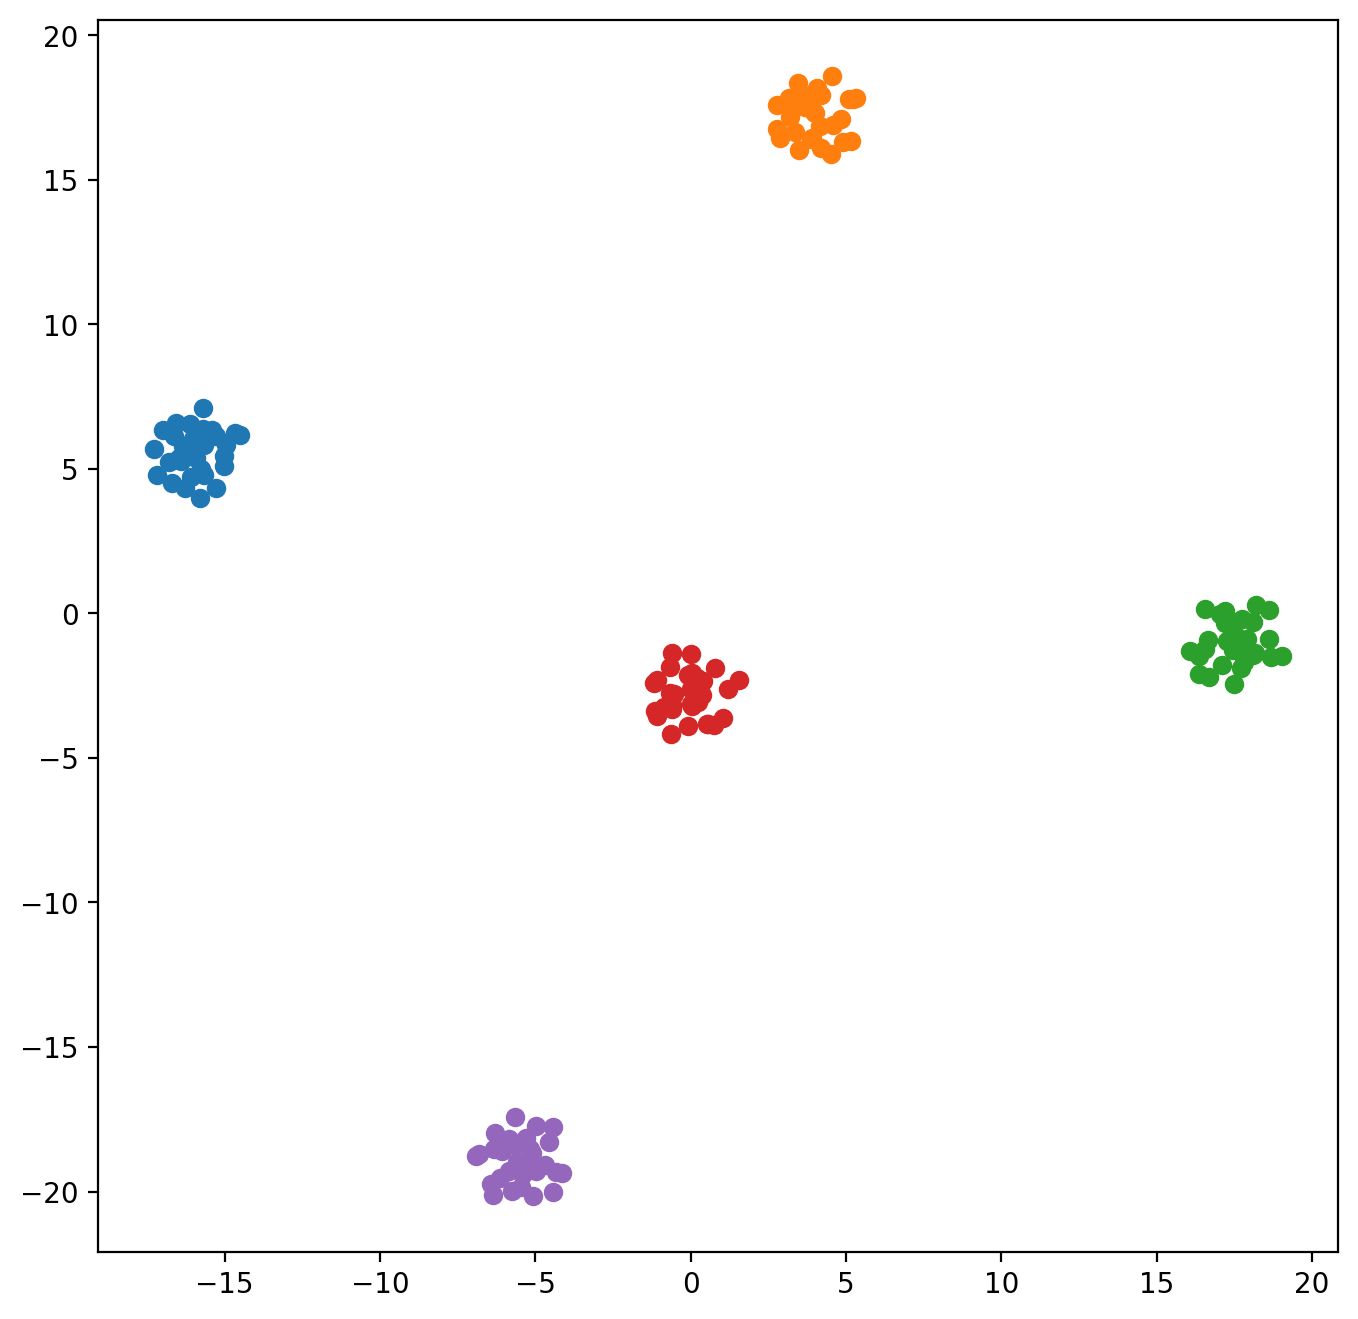

In [7]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(X, no_dims=2, initial_dims=50, perplexity=20.0,max_iter=300)

# plot the points according to the t-SNE projection into 2D space
# color them according to the cluster they belong to!
fig,ax=plt.subplots(figsize=(8,8))
for j in range(n_clusters):
    Y0=Y[j*N_cluster_points:(j+1)*N_cluster_points,0]
    Y1=Y[j*N_cluster_points:(j+1)*N_cluster_points,1]    
    ax.scatter(Y0,Y1)


## Example 3: Multiple Gaussians, finding the true number

In [8]:
# Plot a tSNE-scatterplot, but with some randomly marked points,
# together with the corresponding high-dimensional data points plotted
# as curves!

def plot_tsne_with_curves(y0,y1,x,xlabel,n_picks=10,vmin=-0.1,vmax=2):
    random_picks=np.random.randint(np.shape(y0)[0],size=n_picks) # pick some random points
    
    fig=plt.figure(constrained_layout=True,figsize=(8,4))
    gs=fig.add_gridspec(ncols=8,nrows=4)
    scatter_plot=fig.add_subplot(gs[0:4,0:4])
    
    myplot={}
    j=0
    for n0 in range(4):
        for n1 in range(4):
            myplot[j]=fig.add_subplot(gs[n0,4+n1])
            myplot[j].axis('off')
            j+=1
    
    scatter_plot.scatter(y0,y1,c=xlabel)
    scatter_plot.scatter(y0[random_picks],y1[random_picks],color="black",alpha=0.7,s=80)
    
    for idx in range(len(random_picks)):
        scatter_plot.text(y0[random_picks[idx]], y1[random_picks[idx]], 
                      str(idx), fontsize=8, color="orange", 
                     alpha=0.8, horizontalalignment='center',
                verticalalignment='center')
    
    for idx,m in enumerate(random_picks):
        if idx<j:
            myplot[idx].plot(x[m,:])
            myplot[idx].text(0.1, 0.75, str(idx), fontsize=12, color="orange", 
                             alpha=0.5, horizontalalignment='center',
                        verticalalignment='center', transform=myplot[idx].transAxes)
            myplot[idx].set_ylim([vmin,vmax])
        
    plt.show()

In [9]:
def my_generator1D(batchsize,x): # produce a batch of curves, a random number of Gaussian
    maxNum=2 # the maximum number of Gaussians
    NumGaussians=np.random.randint(maxNum+1,size=batchsize) # select the number, for each sample
    Curves=np.zeros([batchsize,len(x)])
    for j in range(maxNum):  #Loop over number of Gaussians
        R=np.random.uniform(low=0.1,high=0.11,size=batchsize) # width
        A=np.random.uniform(low=0.9,high=1.0,size=batchsize) # amplitude
        x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8) # position
        Curves+=(j<=NumGaussians[:,None]-1)*A[:,None]*np.exp(-((x[None,:]-x0[:,None])/R[:,None])**2)
    Curves+=0.1*np.random.randn(batchsize,len(x)) # add a bit of background noise on top
    return( Curves, NumGaussians )

n_dim=100
x=np.linspace(-1,1,n_dim)
N=2000 # how many curves

X,Xlabel=my_generator1D(N,x) 
# small x is the coordinate, capital X are the high-dim. "data points", meaning samples of curves!
print(np.shape(x))
print(np.shape(X))
print(np.shape(Xlabel))






(100,)
(2000, 100)
(2000,)


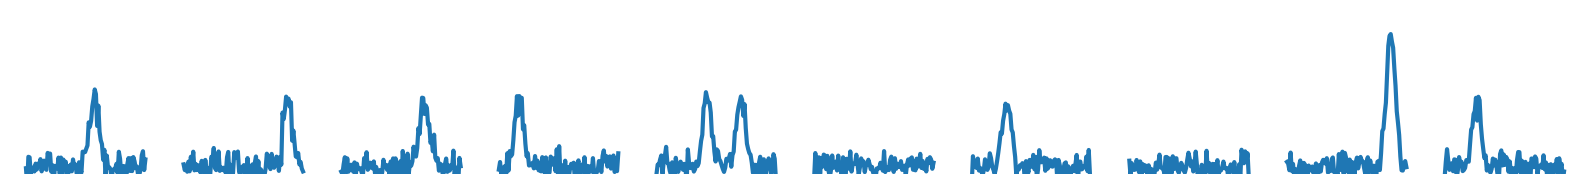

In [10]:
fig,ax=plt.subplots(ncols=10,nrows=1,figsize=(10,1))
for n in range(10):
    ax[n].plot(X[n,:])
    ax[n].set_ylim([-0.1,2])
    ax[n].axis('off')
plt.show()

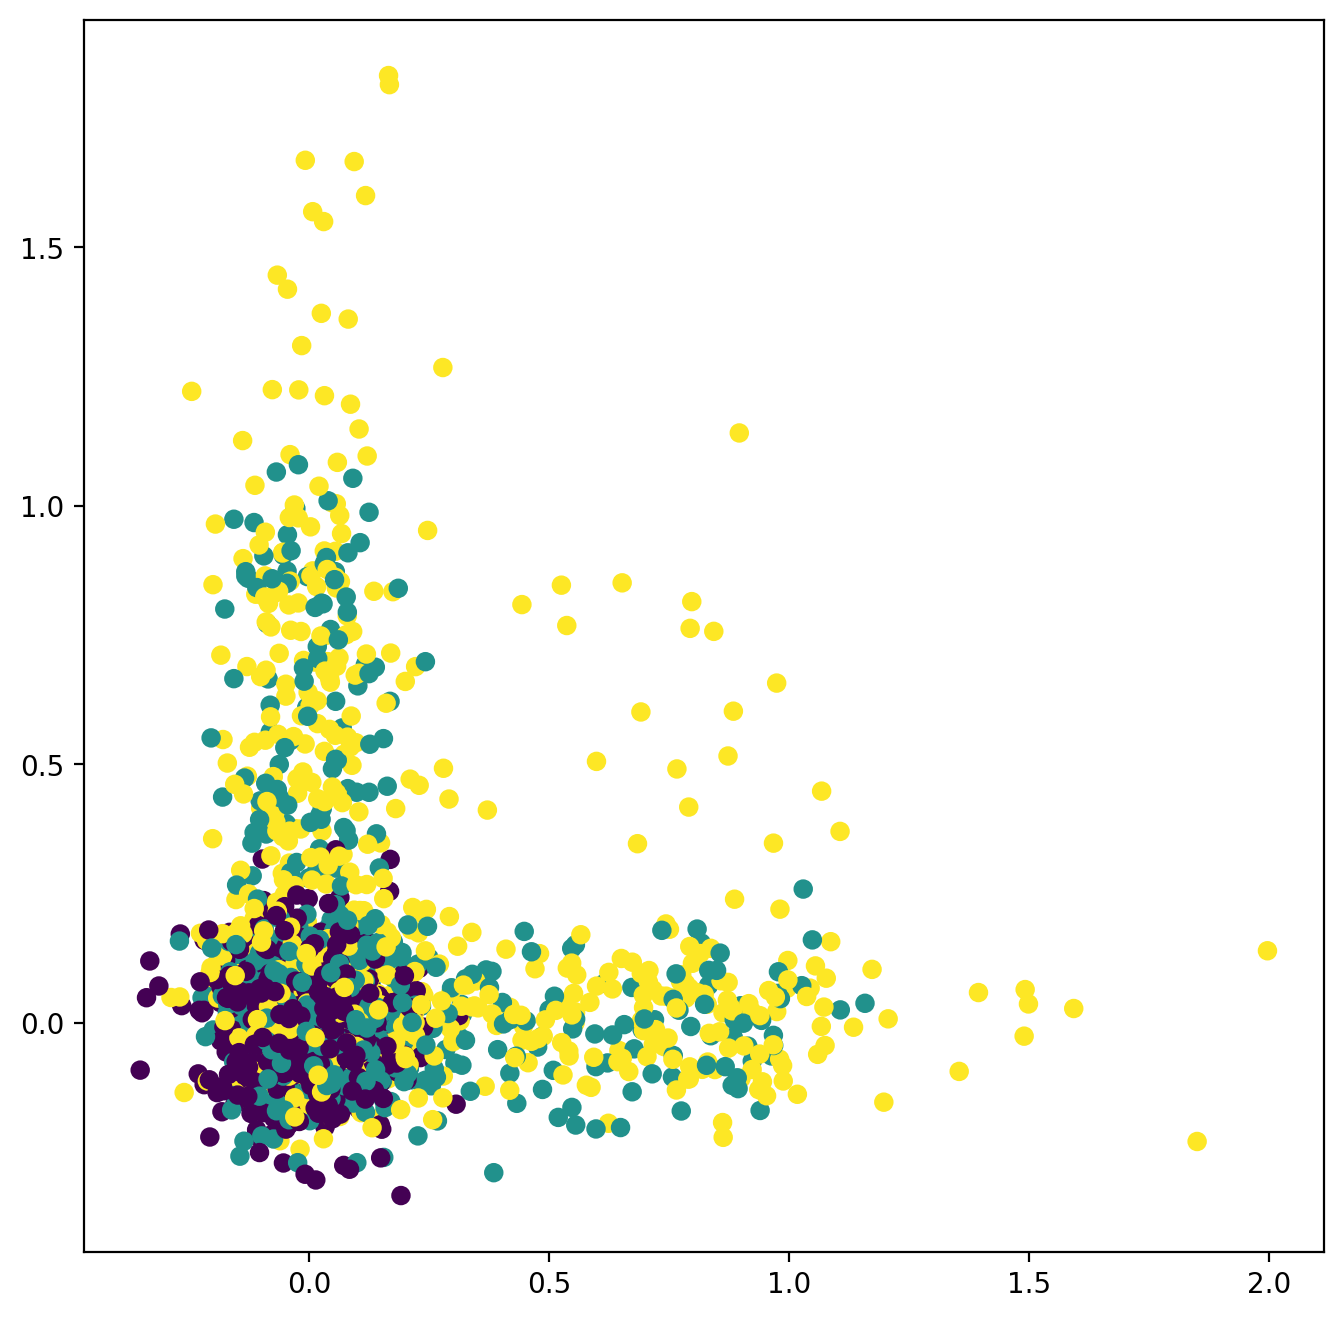

In [11]:
# plot these points in a projection into 2D space

# pick two arbitrary coordinates
j0=17
j1=35

plt.figure(figsize=(8,8))
X0=X[:,j0]
X1=X[:,j1]    
plt.scatter(X0,X1,c=Xlabel)
plt.show()

In [12]:
# now apply t-SNE to reduce to two dimensions in a smart way!

Y=tsne(X, 2, 20, 30.0, max_iter=300)

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 2000...
Computing P-values for point 500 of 2000...
Computing P-values for point 1000 of 2000...
Computing P-values for point 1500 of 2000...
Mean value of sigma: 0.626306
Iteration 10: error is 20.545972
Iteration 20: error is 17.486361
Iteration 30: error is 16.132191
Iteration 40: error is 15.718302
Iteration 50: error is 15.660781
Iteration 60: error is 15.653214
Iteration 70: error is 15.562531
Iteration 80: error is 15.425574
Iteration 90: error is 15.378554
Iteration 100: error is 15.357598
Iteration 110: error is 2.042179
Iteration 120: error is 1.753296
Iteration 130: error is 1.592258
Iteration 140: error is 1.470898
Iteration 150: error is 1.376809
Iteration 160: error is 1.304614
Iteration 170: error is 1.248912
Iteration 180: error is 1.205406
Iteration 190: error is 1.171016
Iteration 200: error is 1.143306
Iteration 210: error is 1.120556
Iteration 220: error is 1.101853

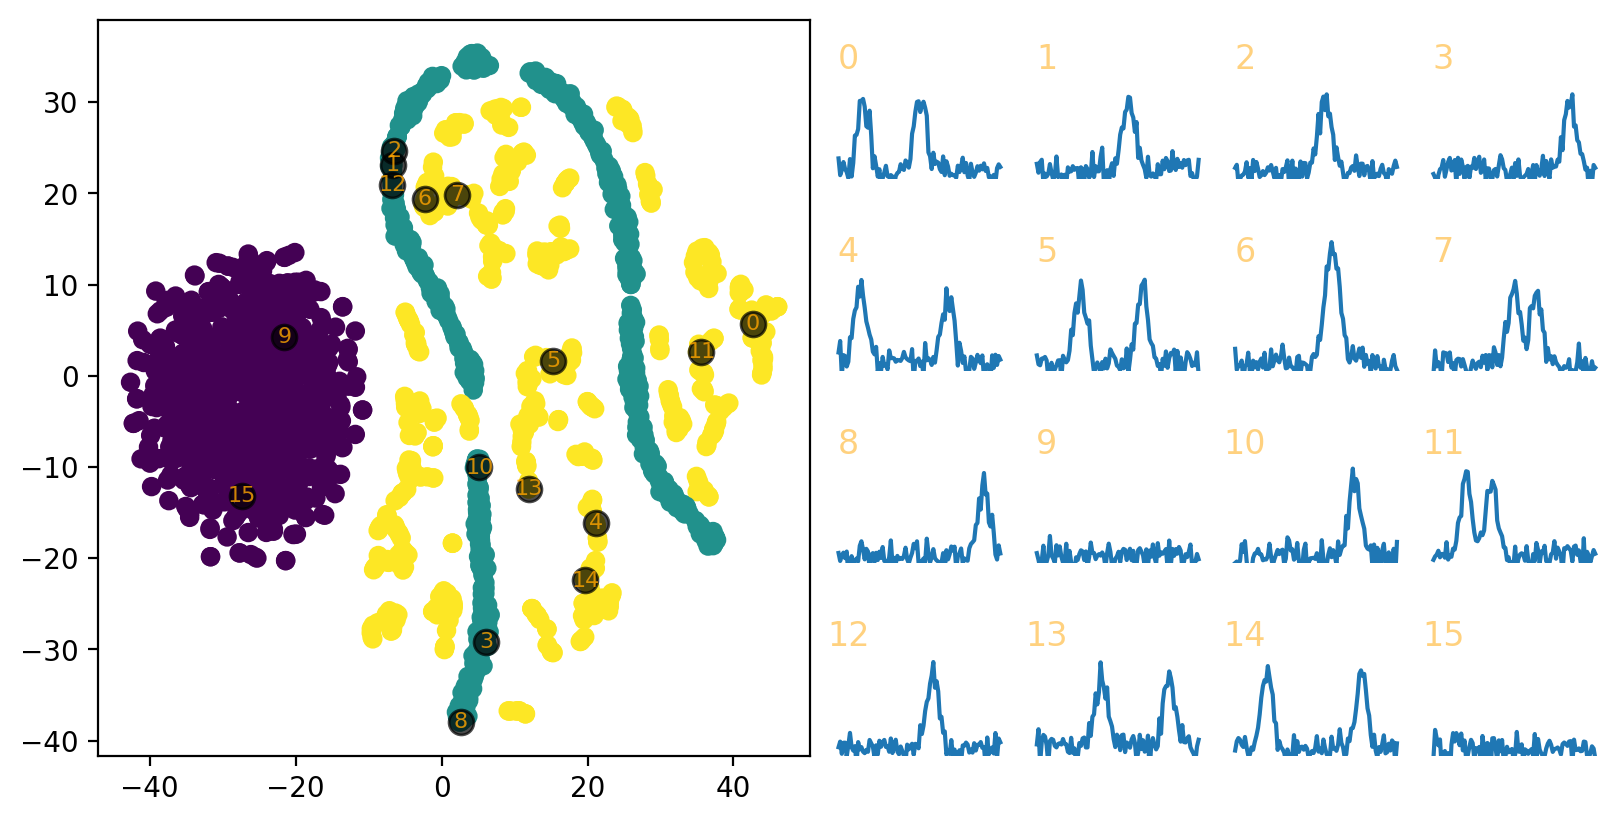

In [13]:
plot_tsne_with_curves(Y[:,0],Y[:,1],X,Xlabel,n_picks=16)

## Suggested Tasks
1. Change the perplexity variable in one (or more) of the examples above. What effect does perplexity have on the result tSNE distribution?
2. Modify Example 3 to use different to use different sample curves